
- Costruire un dataset di grafi di spin glass di piccola taglia (# basso di nodi) e studiare come l'apprendimento dell'energia da parte della GNN cambia al variare della connettività del grafo. Ad esempio fissando a 10 il numero di nodi, il numero di edges può essere cambiato da 9 (open spin glass chain) a 45 (fully connected spin glass) , magari provando 9, 15, 25, 45. Si costruiscono 4 dataset e si allena la stessa GNN separatamente su questi dataset in modo supervised per fare poi il confronto. (Livello medio)

- Costruire un dataset di grafi di spin glass a taglia e connettività fissati (# nodi non troppo alto). Studiare la comparazione tra l'apprendimento della magnetizzazione o dell'energia tra un MLP e una GNN.  Ovviamente in questo caso va ricavata la matrice di adiacenza e la matrice delle features a partire dai grafi per poter allenare l'MLP. (Livello medio)


In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show()
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 


    return -E/2 - E_h  # divide by 2 to avoid double counting

Device:  cuda


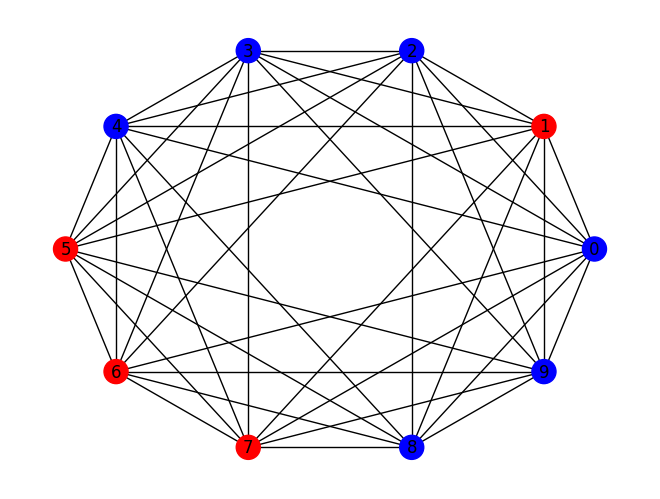

energy for this configuration:  0.9656138499721706


In [2]:
G = initialize_graph(10, periodic=True, n_dimensions=4)
plot_graph(G)
h = 0
print("energy for this configuration: " , calculate_energy(G, h))

In [3]:
#extract the adjacency matrix
A = nx.adjacency_matrix(G).todense()
print(A)
print()
#extract the node features
X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
print(X)
print()

M = np.concatenate([X, A], axis=1)

print(M)


[[ 0.          0.95335917 -0.60753507 -0.28843756 -0.62380257  0.
  -0.06466628  0.87939805 -0.94724267  0.18071724]
 [ 0.95335917  0.          0.25653123  0.81665519 -0.46100934  0.35626381
   0.         -0.63979178  0.6795479  -0.42292593]
 [-0.60753507  0.25653123  0.          0.15209676  0.44357387  0.79027223
   0.82207363  0.         -0.09085086 -0.25676338]
 [-0.28843756  0.81665519  0.15209676  0.          0.87540451 -0.44497937
   0.61236172 -0.77114157  0.          0.87369324]
 [-0.62380257 -0.46100934  0.44357387  0.87540451  0.          0.59716328
  -0.49873173 -0.75515723  0.08894588  0.        ]
 [ 0.          0.35626381  0.79027223 -0.44497937  0.59716328  0.
   0.83235857  0.57510512  0.58623877  0.44150566]
 [-0.06466628  0.          0.82207363  0.61236172 -0.49873173  0.83235857
   0.          0.48204897 -0.05880309  0.25343107]
 [ 0.87939805 -0.63979178  0.         -0.77114157 -0.75515723  0.57510512
   0.48204897  0.         -0.30261889 -0.4318223 ]
 [-0.94724267  0

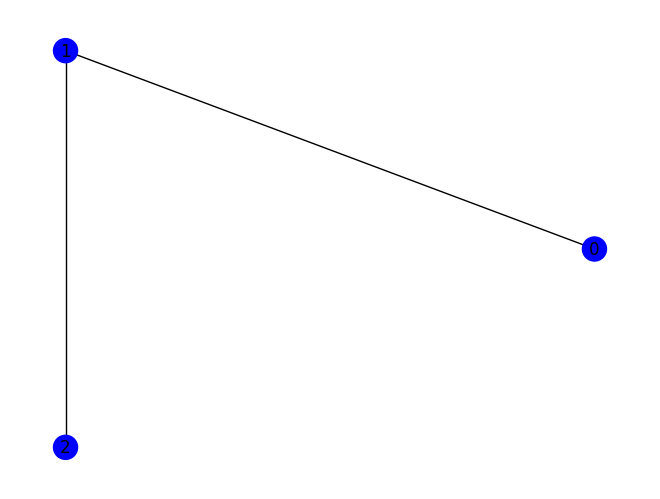

Data object:  Data(x=[3, 1], edge_index=[2, 2], y=[1], edge_weight=[2])
tensor([[0, 1],
        [1, 2]])
Features:  tensor([[1.],
        [1.],
        [1.]])
Edges weight:  tensor([0.6086, 0.6124])
The general graph feature:  tensor([-0.6105])


In [4]:
n_nodes = 3
h = 0
periodic = False
n_dimensions = 1

G = initialize_graph(n_nodes,periodic=periodic, n_dimensions=n_dimensions)
plot_graph(G)
X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)


# create a torch geometric data object from G, using the from_networkx function 
data = Data(x = X, 
            edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
            edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
            y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) 
print('Data object: ', data)

print(data.edge_index)

print('Features: ', data.x)
print('Edges weight: ', data.edge_weight)
print('The general graph feature: ', data.y)



In [61]:
# GNN model
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv

import torch
import matplotlib.pyplot as plt
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.profile import get_model_size
from torch.nn import Softmax, Linear
from torch_geometric.nn import global_max_pool, SAGEConv
from torch_geometric.loader import DataLoader


class GNN(torch.nn.Module):
    def __init__(self,hidden_channels_1=16, hidden_channels_2=16, hidden_channels_3=16,hidden_channels_4 = 16, hidden_linear=16,
                 lr = 1e-5, weight_decay=1e-3, dropout=0.5, num_node_features=1, num_classes=1):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_node_features,hidden_channels_1)
        self.conv2 = GraphConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GraphConv(hidden_channels_2, hidden_channels_3)
        self.conv4 = GraphConv(hidden_channels_3, hidden_channels_4)

        self.pool = global_max_pool

        self.linear1 = Linear(hidden_channels_4, hidden_linear)
        self.linear2 = Linear(hidden_linear, num_classes)

        

        self.dropout = torch.nn.Dropout(dropout)

        # we should consider also batch normalization in case of overfitting



        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Loss function:
        self.criterion = torch.nn.MSELoss()

        
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))

        x = self.pool(x, data.batch) # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]

        #x = torch.flatten(x) # not needed since we are using global_max_pool
        #print(x.shape)
        x = self.dropout(x)
        x = F.leaky_relu(self.linear1(x))
        out = self.linear2(x)

        return out
    

    
    def train_step(self, data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(data)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, data.y)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        
        return loss.item()
    




In [73]:
import seaborn as sns

palette = sns.color_palette("coolwarm", as_cmap=True)

def plot_loss( train_losses, test_losses, figsize = (10, 5)):
    fig = plt.figure(figsize=(figsize))
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title('Losses', fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig('Graph_mnist_losses.png')
    plt.show()
    return fig


def train_model(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model'):
    best_loss = np.inf
    patience_counter = 0

    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    print('Training ...')
    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            mini_batch.to(device)
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                mini_batch.to(device)
                prediction = model.forward(mini_batch)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, mini_batch.y).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [122]:
# create a dataset with the energy as label

dataset = []
graphs = []

n_nodes = 10
h = 0
periodic = True
n_dimensions = 1

for i in range(1000):
    G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
    #A = nx.adjacency_matrix(G).todense()
    X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)

    graphs.append(G)
    dataset.append(
        Data(x = X, 
            edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
            edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
            y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) )   

In [125]:
# training hyperparameters
batch_size = 1
num_epochs = 30
lr = 1e-4
weight_decay = 1e-3
dropout = 0.5
patience = 10

# model hyperparameters
hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

model_name = f"model_{n_nodes}_{n_dimensions}_{h}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}"


# Creating dataloaders for storing and shuffling training data:
train_loader = DataLoader(dataset=dataset[:int(len(dataset) * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset[int(len(dataset) * 0.8):], batch_size=1, shuffle=False)

#define the model with the hyperparameters
model = GNN(hidden_channels_1=hidden_channels_1, 
            hidden_channels_2=hidden_channels_2, 
            hidden_channels_3=hidden_channels_3, 
            hidden_channels_4=hidden_channels_4,
            hidden_linear=hidden_linear,
            lr=lr, weight_decay=weight_decay, dropout=dropout)
model.to(device);

print(model)    

# Model size and number of parameters of the model:
print(44 * '-')
print("Model:")
print('Model size (bytes):\t\t\t\t     ', get_model_size(model))
print("Number of parameters:\t\t\t\t   ", sum(p.numel() for p in model.parameters()))
print(44 * '-')


GNN(
  (conv1): GraphConv(1, 16)
  (conv2): GraphConv(16, 32)
  (conv3): GraphConv(32, 32)
  (conv4): GraphConv(32, 64)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (criterion): MSELoss()
)
--------------------------------------------
Model:
Model size (bytes):				      43990
Number of parameters:				    9457
--------------------------------------------


Training ...
Ep 1 	| Loss 0.79217 	| Test Loss 0.77268
Ep 2 	| Loss 0.75928 	| Test Loss 0.71949
Ep 3 	| Loss 0.64839 	| Test Loss 0.61411
Ep 4 	| Loss 0.49863 	| Test Loss 0.41438
Ep 5 	| Loss 0.40933 	| Test Loss 0.36398
Ep 6 	| Loss 0.3565 	| Test Loss 0.33013
Ep 7 	| Loss 0.32671 	| Test Loss 0.34546
Ep 8 	| Loss 0.30285 	| Test Loss 0.32845
Ep 9 	| Loss 0.29172 	| Test Loss 0.30793
Ep 10 	| Loss 0.25264 	| Test Loss 0.2765
Ep 11 	| Loss 0.25367 	| Test Loss 0.27509
Ep 12 	| Loss 0.25968 	| Test Loss 0.27546
Ep 13 	| Loss 0.2343 	| Test Loss 0.23524
Ep 14 	| Loss 0.23033 	| Test Loss 0.25715
Ep 15 	| Loss 0.21105 	| Test Loss 0.27063
Ep 16 	| Loss 0.2322 	| Test Loss 0.2542
Ep 17 	| Loss 0.21796 	| Test Loss 0.26757
Ep 18 	| Loss 0.21632 	| Test Loss 0.25915
Ep 19 	| Loss 0.21752 	| Test Loss 0.21361
Ep 20 	| Loss 0.21819 	| Test Loss 0.28619
Ep 21 	| Loss 0.21933 	| Test Loss 0.22511
Ep 22 	| Loss 0.2073 	| Test Loss 0.20788
Ep 23 	| Loss 0.19803 	| Test Loss 0.25041
Ep 24 	| Loss

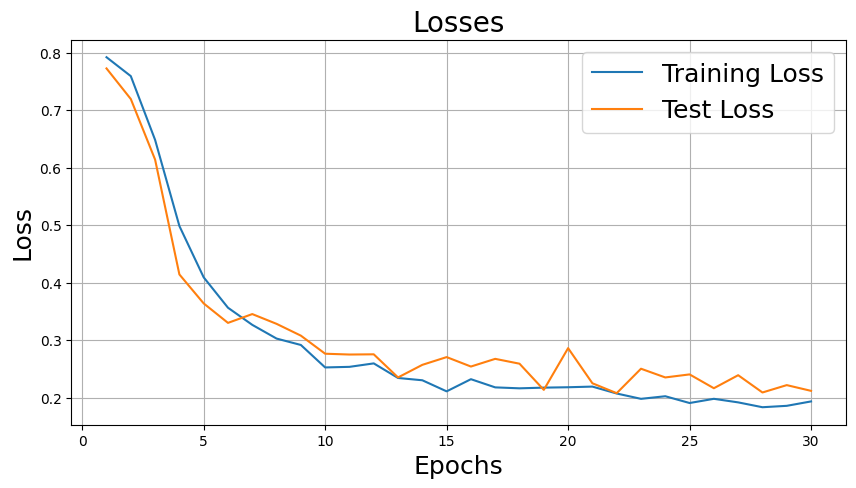

In [126]:
# start the training 
train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience, model_name)
fig = plot_loss(train_losses, test_losses)

In [127]:
# translate the model name into values
def print_values_from_model_name(model_name, print_values=True, return_dict = False): 
    values = model_name.split('_')
    # create a dictionary to store the values 
    dict = {"n_nodes": values[1], "n_dimensions": values[2], "h": values[3], "hidden_channels_1": values[4], "hidden_channels_2": values[5], "hidden_channels_3": values[6], "hidden_channels_4": values[7], "hidden_linear": values[8], "lr": values[9], "weight_decay": values[10], "dropout": values[11]}
    if print_values:
        print("Values from model name:")
        for key, value in dict.items():
            print(f"{key}: {value}")
    if return_dict:
        return dict
    
print_values_from_model_name(model_name)

Values from model name:
n_nodes: 10
n_dimensions: 1
h: 0
hidden_channels_1: 16
hidden_channels_2: 32
hidden_channels_3: 32
hidden_channels_4: 64
hidden_linear: 32
lr: 0.0001
weight_decay: 0.001
dropout: 0.5


In [144]:
def test_trained_model(model_name, test_loader):

    values = print_values_from_model_name(model_name, print_values=False, return_dict=True)

    trained_model = GNN(hidden_channels_1= int(values["hidden_channels_1"]),
                hidden_channels_2= int(values["hidden_channels_2"]),
                hidden_channels_3= int(values["hidden_channels_3"]),
                hidden_channels_4= int(values["hidden_channels_4"]),
                hidden_linear= int(values["hidden_linear"]),
                lr= float(values["lr"]), weight_decay= float(values["weight_decay"]), dropout= float(values["dropout"]))
    trained_model.load_state_dict(torch.load(model_name + ".pth"))
    trained_model.to(device)

    with torch.no_grad():
        predictions = []
        true_values = []
        for i, mini_batch in enumerate(test_loader):
            mini_batch.to(device)
            prediction = trained_model.forward(mini_batch)
            predictions.append(prediction.item())
            true_values.append(mini_batch.y.item())
        plt.scatter(true_values, predictions)
        plt.plot(true_values, true_values, color='red')
        plt.xlabel('True energy')
        plt.ylabel('Predicted energy')
        plt.title('Predicted vs True energy')
        plt.grid(True)
        plt.show()
    
    # print the mean squared error
    mse = np.mean((np.array(predictions) - np.array(true_values))**2)
    print(f"Mean squared error: {mse}")

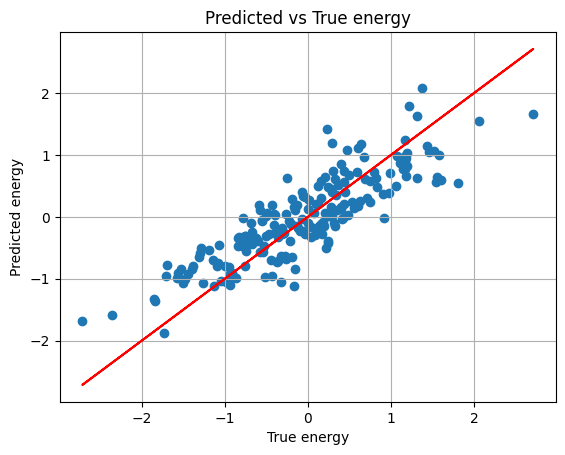

In [129]:
test_trained_model(model_name, test_loader)

In [130]:
# create a dataset with the energy as label
def create_dataset(n_nodes=10, h=0, periodic= True, n_dimensions=1, n_samples=1000):
    dataset = []
    graphs = []

    for i in range(n_samples):
        G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)

        graphs.append(G)
        dataset.append(
            Data(x = X, 
                edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
                edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
                y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) )   

    return dataset, graphs

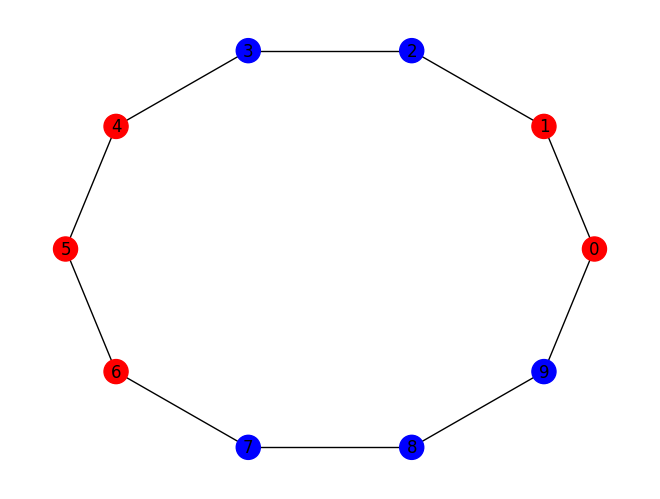

In [131]:
# spin glass with 
h = 3
n_dimensions = 1
n_samples = 1000


dataset, graphs = create_dataset(n_nodes=10, h=h, periodic=True, n_dimensions=n_dimensions, n_samples=n_samples)

plot_graph(graphs[0])


In [132]:
# train the model
batch_size = 1
num_epochs = 30
lr = 1e-3
weight_decay = 1e-3
dropout = 0.5
patience = 10

hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

model_name = f"model_{n_nodes}_{n_dimensions}_{h}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}"

train_loader = DataLoader(dataset=dataset[:int(len(dataset) * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset[int(len(dataset) * 0.8):], batch_size=1, shuffle=False)

model = GNN(hidden_channels_1=hidden_channels_1,
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4,
            hidden_linear=hidden_linear,
            lr=lr, weight_decay=weight_decay, dropout=dropout)
model.to(device);

train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience, model_name)

Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 69.66264 	| Test Loss 33.75155
Ep 2 	| Loss 39.18671 	| Test Loss 30.358
Ep 3 	| Loss 34.90584 	| Test Loss 28.88817
Ep 4 	| Loss 32.87373 	| Test Loss 29.83811
Ep 5 	| Loss 29.66287 	| Test Loss 28.31773
Ep 6 	| Loss 27.26066 	| Test Loss 23.3839
Ep 7 	| Loss 25.6521 	| Test Loss 19.46006
Ep 8 	| Loss 25.74462 	| Test Loss 28.44928
Ep 9 	| Loss 26.17491 	| Test Loss 27.89969
Ep 10 	| Loss 20.71201 	| Test Loss 24.23108
Ep 11 	| Loss 23.06127 	| Test Loss 20.34524
Ep 12 	| Loss 22.7621 	| Test Loss 24.42488
Ep 13 	| Loss 22.99531 	| Test Loss 24.29089
Ep 14 	| Loss 21.93718 	| Test Loss 20.01883
Ep 15 	| Loss 21.8486 	| Test Loss 18.80372
Ep 16 	| Loss 20.92386 	| Test Loss 21.73395
Ep 17 	| Loss 18.87575 	| Test Loss 17.5656
Ep 18 	| Loss 20.77903 	| Test Loss 18.59183
Ep 19 	| Loss 20.37443 	| Test Loss 19.42153
Ep 20 	| Loss 20.18854 	| Test Loss 23.49824
Ep 21 	| Loss 19.6195 	| Test Loss 21.66229
Ep 22 	| Loss 17.74002 	| Test Loss 18.64491
Ep 23 	| Loss 17.29471 	| T

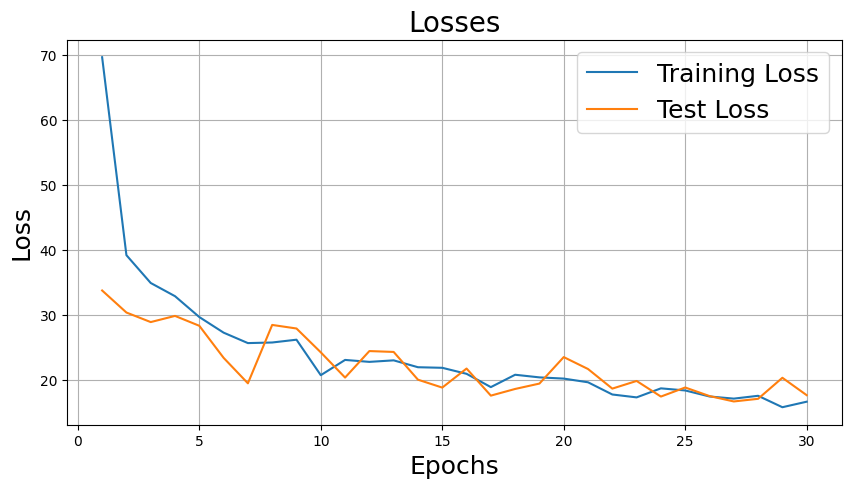

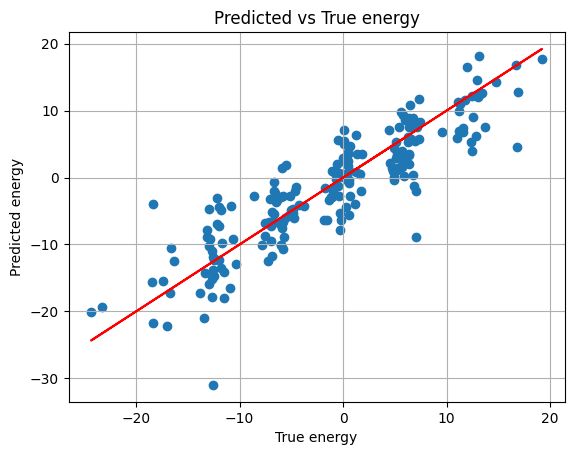

In [133]:
fig = plot_loss(train_losses, test_losses)

# test the model
test_trained_model(model_name, test_loader)

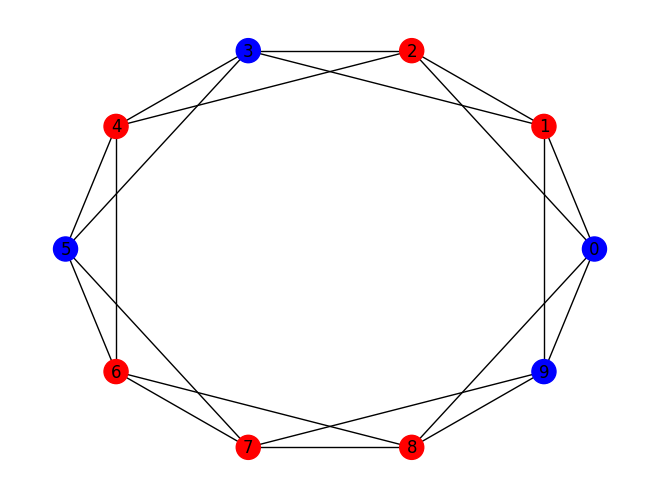

In [134]:
# spin glass with 
n_nodes = 10
periodic = True
h = 0
n_dimensions = 2
n_samples = 1000


dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples)

plot_graph(graphs[0])


In [152]:
def set_model_name(n_nodes, n_dimensions, h, periodic,n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout):
    return f"model_{n_nodes}_{n_dimensions}_{h}_{periodic}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}"

In [153]:
# train the model
batch_size = 1
num_epochs = 30
lr = 1e-4
weight_decay = 1e-3
dropout = 0.5
patience = 10

hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1,
                            hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout)
print(model_name)
train_loader = DataLoader(dataset=dataset[:int(len(dataset) * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset[int(len(dataset) * 0.8):], batch_size=1, shuffle=False)

model = GNN(hidden_channels_1=hidden_channels_1,
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4,
            hidden_linear=hidden_linear,
            lr=lr, weight_decay=weight_decay, dropout=dropout)
model.to(device);

train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience, model_name)

model_10_4_0_True_1000_16_32_32_64_32_0.0001_0.001_0.5
Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 3.27363 	| Test Loss 3.06556
Ep 2 	| Loss 3.21669 	| Test Loss 3.07384
Ep 3 	| Loss 3.15807 	| Test Loss 2.96001
Ep 4 	| Loss 3.02543 	| Test Loss 2.83851
Ep 5 	| Loss 2.8391 	| Test Loss 2.4852
Ep 6 	| Loss 2.46013 	| Test Loss 2.36261


KeyboardInterrupt: 

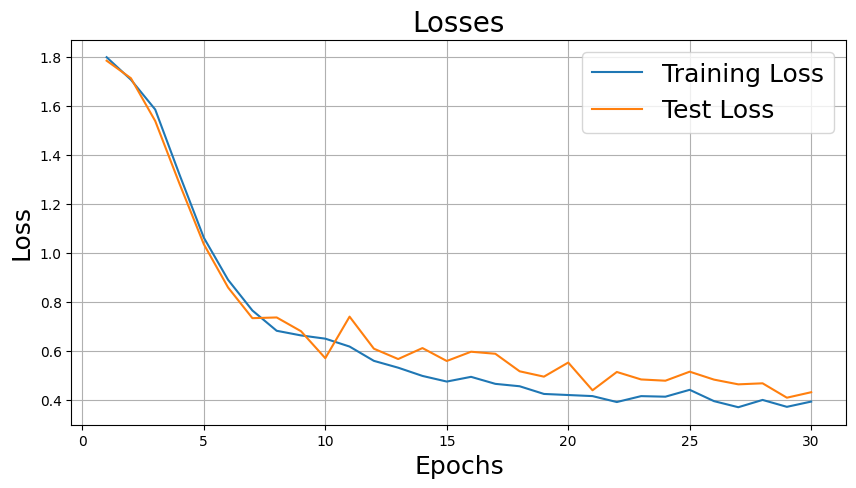

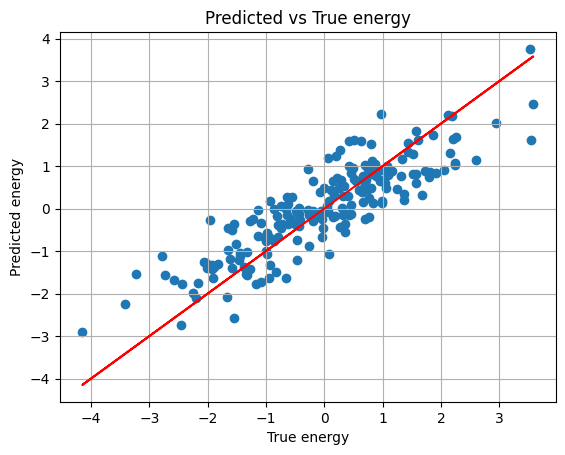

In [136]:
fig = plot_loss(train_losses, test_losses)

# test the model
test_trained_model(model_name, test_loader)

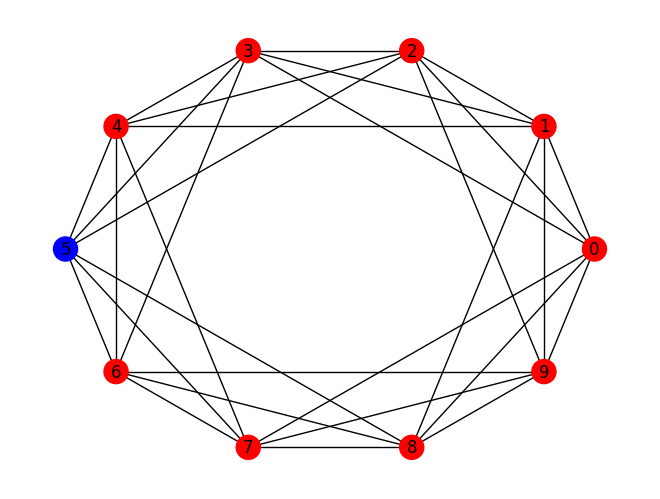

number of connections:  30


In [141]:
# spin glass with 
n_nodes = 10
periodic = True
h = 0
n_dimensions = 3
n_samples = 1000


dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples)

plot_graph(graphs[0])
print('number of connections: ', len(graphs[0].edges))


In [142]:
# train the model
batch_size = 1
num_epochs = 30
lr = 1e-4
weight_decay = 1e-3
dropout = 0.5
patience = 10

hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

model_name = f"model_{n_nodes}_{n_dimensions}_{h}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}"

train_loader = DataLoader(dataset=dataset[:int(len(dataset) * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset[int(len(dataset) * 0.8):], batch_size=1, shuffle=False)

model = GNN(hidden_channels_1=hidden_channels_1,
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4,
            hidden_linear=hidden_linear,
            lr=lr, weight_decay=weight_decay, dropout=dropout)
model.to(device);

train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience, model_name)

Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 2.55064 	| Test Loss 2.76395
Ep 2 	| Loss 2.5427 	| Test Loss 2.75126
Ep 3 	| Loss 2.50779 	| Test Loss 2.68714
Ep 4 	| Loss 2.417 	| Test Loss 2.57871
Ep 5 	| Loss 2.23637 	| Test Loss 2.29688
Ep 6 	| Loss 2.0247 	| Test Loss 1.96507
Ep 7 	| Loss 1.79468 	| Test Loss 1.80972
Ep 8 	| Loss 1.457 	| Test Loss 1.61176
Ep 9 	| Loss 1.32931 	| Test Loss 1.46319
Ep 10 	| Loss 1.17596 	| Test Loss 1.1384
Ep 11 	| Loss 1.10514 	| Test Loss 1.20688
Ep 12 	| Loss 1.07167 	| Test Loss 1.07288
Ep 13 	| Loss 0.95192 	| Test Loss 1.12095
Ep 14 	| Loss 0.89895 	| Test Loss 1.04492
Ep 15 	| Loss 0.80022 	| Test Loss 0.83108
Ep 16 	| Loss 0.81207 	| Test Loss 0.74608
Ep 17 	| Loss 0.75678 	| Test Loss 0.80247
Ep 18 	| Loss 0.7182 	| Test Loss 0.81822
Ep 19 	| Loss 0.75647 	| Test Loss 0.8764
Ep 20 	| Loss 0.69493 	| Test Loss 0.88206
Ep 21 	| Loss 0.66698 	| Test Loss 0.85367
Ep 22 	| Loss 0.64453 	| Test Loss 0.82842
Ep 23 	| Loss 0.62856 	| Test Loss 0.67789
Ep 24 	| Loss 0.60037 	| Test

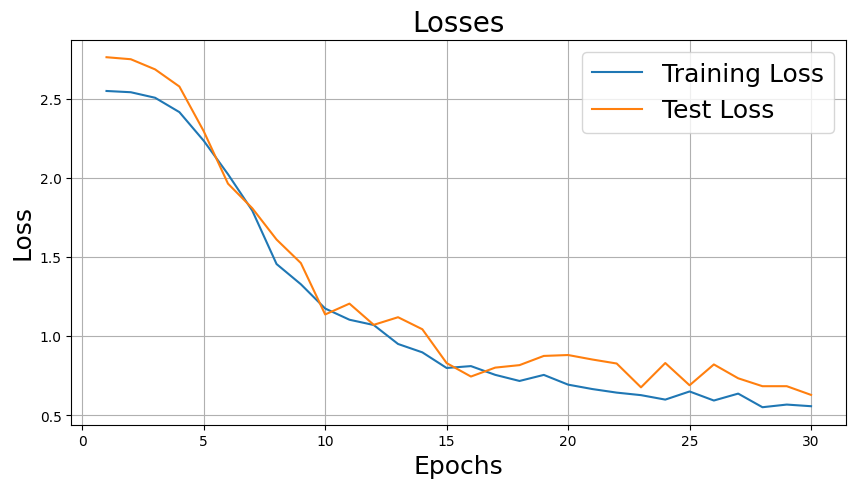

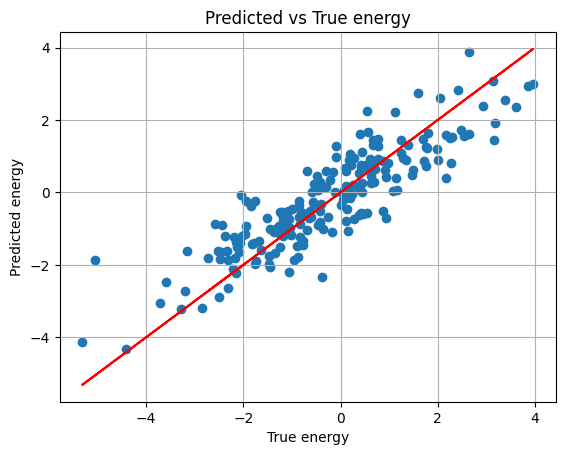

Mean squared error: 0.625885012843423


In [145]:
fig = plot_loss(train_losses, test_losses)

# test the model
test_trained_model(model_name, test_loader)

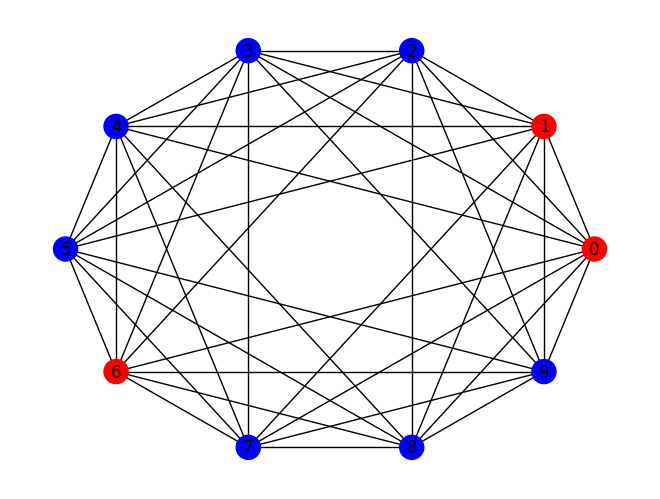

number of connections:  40


In [149]:
# spin glass with 
n_nodes = 10
periodic = True
h = 0
n_dimensions = 4
n_samples = 1000


dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples)

plot_graph(graphs[0])
print('number of connections: ', len(graphs[0].edges))


In [150]:
# train the model
batch_size = 1
num_epochs = 30
lr = 1e-4
weight_decay = 1e-3
dropout = 0.5
patience = 10

hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

model_name = f"model_{n_nodes}_{n_dimensions}_{h}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}"

train_loader = DataLoader(dataset=dataset[:int(len(dataset) * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset[int(len(dataset) * 0.8):], batch_size=1, shuffle=False)

model = GNN(hidden_channels_1=hidden_channels_1,
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4,
            hidden_linear=hidden_linear,
            lr=lr, weight_decay=weight_decay, dropout=dropout)
model.to(device);

train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience, model_name)

Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 3.2578 	| Test Loss 3.05419
Ep 2 	| Loss 3.17594 	| Test Loss 3.00962
Ep 3 	| Loss 3.03612 	| Test Loss 2.89722
Ep 4 	| Loss 2.76466 	| Test Loss 2.3244
Ep 5 	| Loss 2.25829 	| Test Loss 2.13238
Ep 6 	| Loss 1.94214 	| Test Loss 1.9362
Ep 7 	| Loss 1.7781 	| Test Loss 1.56826
Ep 8 	| Loss 1.6781 	| Test Loss 1.33912
Ep 9 	| Loss 1.42169 	| Test Loss 1.41079
Ep 10 	| Loss 1.21776 	| Test Loss 1.37189
Ep 11 	| Loss 1.09611 	| Test Loss 1.25283
Ep 12 	| Loss 1.0969 	| Test Loss 1.12476
Ep 13 	| Loss 1.0139 	| Test Loss 1.21247
Ep 14 	| Loss 1.04402 	| Test Loss 1.01917
Ep 15 	| Loss 0.95472 	| Test Loss 1.29125
Ep 16 	| Loss 0.98326 	| Test Loss 1.02914
Ep 17 	| Loss 0.8254 	| Test Loss 0.98515
Ep 18 	| Loss 0.86897 	| Test Loss 0.91553
Ep 19 	| Loss 0.83727 	| Test Loss 0.94709
Ep 20 	| Loss 0.85226 	| Test Loss 0.94248
Ep 21 	| Loss 0.79597 	| Test Loss 0.82929
Ep 22 	| Loss 0.80441 	| Test Loss 1.02946
Ep 23 	| Loss 0.71309 	| Test Loss 0.8579
Ep 24 	| Loss 0.80085 	| Test

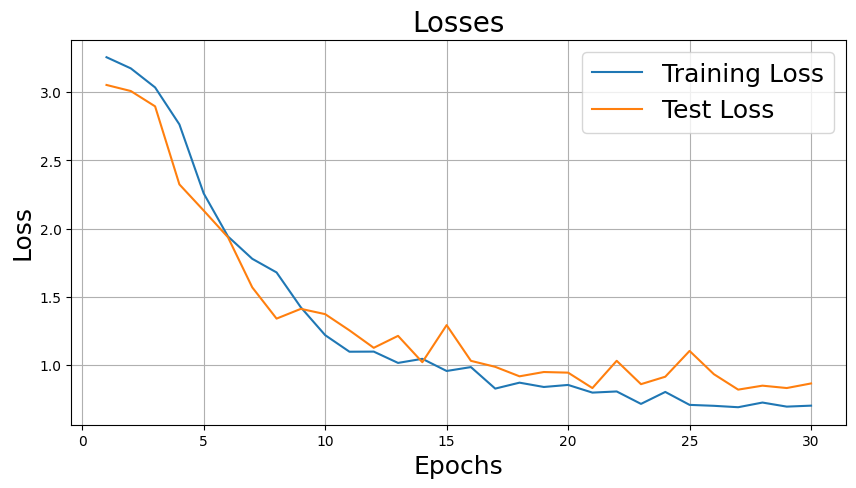

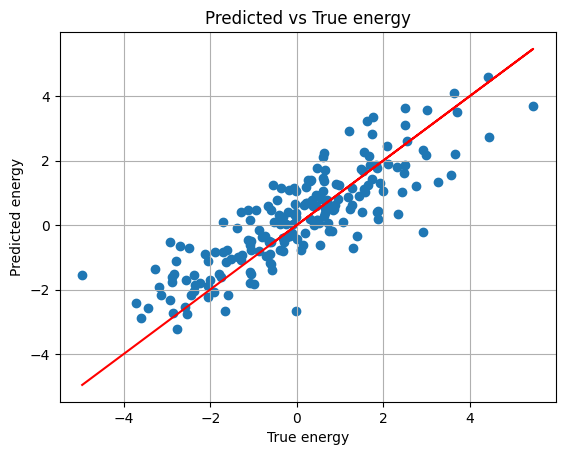

Mean squared error: 0.9281811038165207


In [151]:
fig = plot_loss(train_losses, test_losses)

# test the model
test_trained_model(model_name, test_loader)